# Dear LEGO, what happened??

I used to love playing with LEGO in the 90s when I was growing up, we built many crazy cool empires with my dad. But now, when I play with my kids, LEGO frustrates me more than anything. Instead of getting creative how to build a simple windmill with many wheels out of the "4er, 8er and some rods and wheels", there are funny bits, non-matching shades and users' manuals everwhere. So let's see what changed over time and how much of this is just old mum complaining. 

The data comes from [rebrickable](https://rebrickable.com/downloads/) and fully up-to-date as of today, 3 May 2024. I was inpired by [tidytuesday](https://github.com/rfordatascience/tidytuesday/blob/master/data/2022/2022-09-06/readme.md) for this data analysis. 

Specifically I will explore: 
1. 




# Imports

In [75]:
import csv
import gzip
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# Directory of gzipped files
data_dir = "data/"

# List of gzipped file paths
gz_files = ["colors.csv.gz", "elements.csv.gz", "inventories.csv.gz", "inventory_minifigs.csv.gz", 
           "inventory_parts.csv.gz", "inventory_sets.csv.gz", "part_categories.csv.gz", "part_relationships.csv.gz", 
            "sets.csv.gz", "minifigs.csv.gz", "themes.csv.gz", "parts.csv.gz"]

for file_name in gz_files:
    # construct full file path
    file_path = os.path.join(data_dir, file_name)
    
    data = []

    # Open the gzipped file
    with gzip.open(file_path, "rt") as file:
        reader = csv.reader(file) # CSV header
        columns = next(reader) # for header row
        for row in reader:
           data.append(row)

    # Create a pandas DataFrame
    df_name = file_path.split(".")[0]  # Extract filename without extension
    globals()[df_name] = pd.DataFrame(data, columns = columns)

# so now we have the following list of datasets: 
lego_datasets = ["colors", "elements", "inventories", "inventory_minifigs", "inventory_parts", "inventory_sets", "part_categories", "part_relationships", 
                 "sets", "minifigs", "themes", "parts"]


In [78]:
colors

,id,name,rgb,is_trans
0,-1,[Unknown],0033B2,f
1,0,Black,05131D,f
2,1,Blue,0055BF,f
3,2,Green,237841,f
4,3,Dark Turquoise,008F9B,f
...,...,...,...,...
262,1136,Reddish Orange,CA4C0B,f
263,1137,Sienna Brown,915C3C,f
264,1138,Umber Brown,5E3F33,f
265,1139,Trans-Yellow Opal,F5CD2F,t


The datasets are related to each other and contain the following variables: ![](schema_v3.webp)



I am expecially interested in the aging of trends, so I'll use the _year_ variable of the _sets_ dataset first. There are actually 75 years with data (1949-2025). 

''

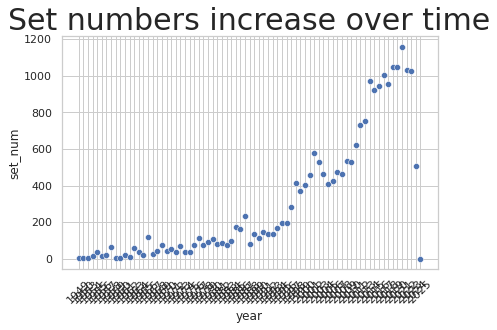

In [38]:
sets_num_agg = sets[['year', 'set_num']].groupby(['year']).agg('count')

sns.set_theme(style = 'whitegrid')
plot = sns.scatterplot(x = 'year', 
                    y = 'set_num', 
                    data = sets_num_agg)
plot.tick_params(axis='x', labelrotation = 45)
plot.set_title("Set numbers increase over time", fontsize = 30)
;

In [39]:
sets_num_agg

,set_num
year,
1949,5
1950,6
1953,4
1954,14
1955,39
...,...
2021,1159
2022,1033
2023,1026


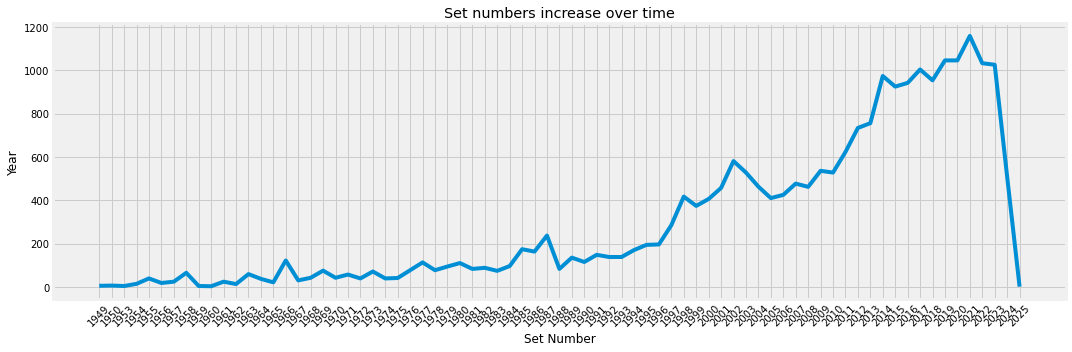

In [68]:
%matplotlib inline

plt.style.use('fast')

sets_num_agg = sets[['year', 'set_num']].groupby(['year']).agg('count')

year = sets_num_agg.index.values
set_number = sets_num_agg['set_num'].values

plt.figure(figsize = (15, 5))
plt.plot(year, set_number)
plt.title('Set numbers increase over time')
plt.xlabel('Set Number')
plt.ylabel('Year')

plt.xticks(rotation = 45)
plt.tight_layout()

plt.show()


## Most common LEGO themes


In [70]:
themes_common = sets.merge(themes, 
                           left_on = 'theme_id', 
                           right_on = 'id', 
                           how = 'left')
themes_common.rename(columns = {'name_y': 'theme_parent', 'name_x': 'theme_child'}, 
                     inplace = True)

,set_num,theme_child,year,theme_id,num_parts,img_url,id,theme_parent,parent_id
0,0003977811-1,Ninjago: Book of Adventures,2022,761,1,https://cdn.rebrickable.com/media/sets/0003977...,761,Activity Books with LEGO Parts,497
1,001-1,Gears,1965,756,43,https://cdn.rebrickable.com/media/sets/001-1.jpg,756,Samsonite,365
2,0011-2,Town Mini-Figures,1979,67,12,https://cdn.rebrickable.com/media/sets/0011-2.jpg,67,Classic Town,50
3,0011-3,Castle 2 for 1 Bonus Offer,1987,199,0,https://cdn.rebrickable.com/media/sets/0011-3.jpg,199,Lion Knights,186
4,0012-1,Space Mini-Figures,1979,143,12,https://cdn.rebrickable.com/media/sets/0012-1.jpg,143,Supplemental,126
...,...,...,...,...,...,...,...,...,...
22673,XWING-1,Mini X-Wing Fighter,2019,158,60,https://cdn.rebrickable.com/media/sets/xwing-1...,158,Star Wars,
22674,XWING-2,X-Wing Trench Run,2019,158,52,https://cdn.rebrickable.com/media/sets/xwing-2...,158,Star Wars,
22675,YODACHRON-1,Yoda Chronicles Promotional Set,2013,158,413,https://cdn.rebrickable.com/media/sets/yodachr...,158,Star Wars,
22676,YTERRIER-1,Yorkshire Terrier,2018,598,0,https://cdn.rebrickable.com/media/sets/yterrie...,598,Promotional,


''

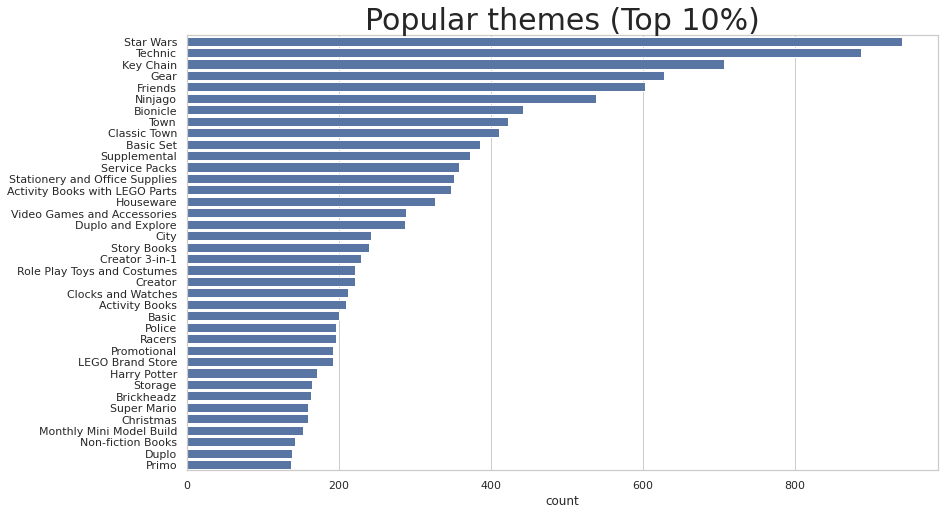

In [74]:
sns.set_theme(rc = {'figure.figsize':(12,8)}, 
             style = 'whitegrid')

plot = sns.countplot(y = 'theme_parent', data = themes_common,
             order=themes_common.theme_parent.value_counts().iloc[:38].index)
plot.set_title("Popular themes (Top 10%)", fontsize = 30)
plot.set_ylabel("")
;


## Color composition over time 
This great idea for visualisation came from [David Robinson](https://www.youtube.com/watch?v=CTWkJrvfRBc) at Tidy Tuesday (written in R). 

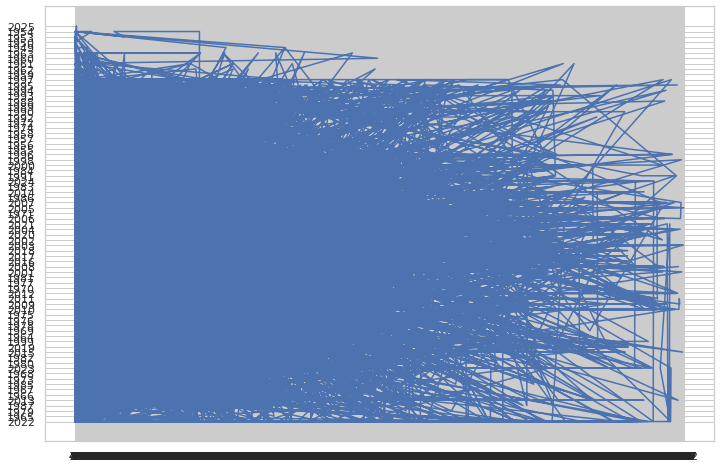

In [204]:
fig, ax = plt.subplots()
ax.plot(np.array(themes_common["num_parts"].values), 
        np.array(themes_common["year"].values))
plt.show()

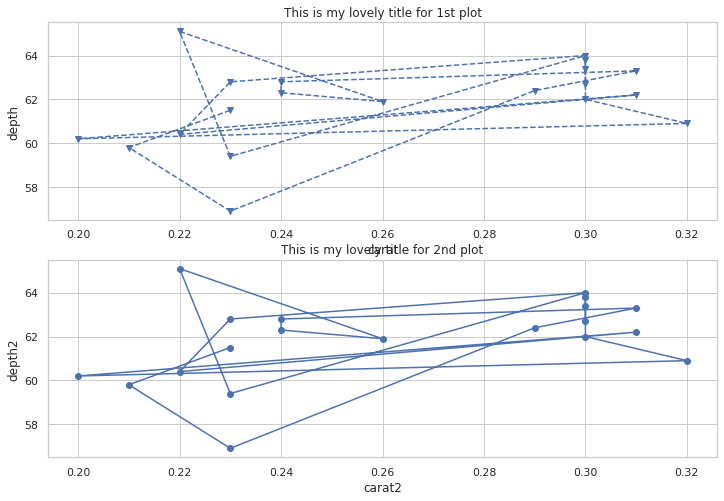

In [218]:
diamonds = sns.load_dataset('diamonds', cache=True, data_home=None)
diamonds_top20 = diamonds.head(20)

fig, ax = plt.subplots(2, 1, sharey = True)
ax[0].plot(diamonds_top20['carat'].values, 
        diamonds_top20['depth'].values,
       marker = 'v', 
       linestyle = '--')
ax[1].plot(diamonds_top20['carat'].values, 
        diamonds_top20['depth'].values,
       marker = 'o', 
       linestyle = '-')
ax[0].set(xlabel='carat', 
       ylabel='depth',
       title='This is my lovely title for 1st plot')

ax[1].set(xlabel='carat2', 
       ylabel='depth2',
       title='This is my lovely title for 2nd plot')

# ax.set_title('this is my overwritten title')
# ax.grid()

plt.show()


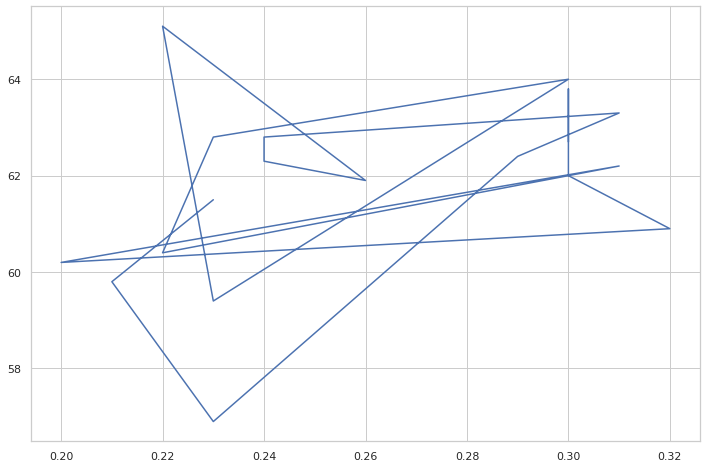

In [220]:
plt.plot(diamonds_top20['carat'].values, 
        diamonds_top20['depth'].values)
plt.show()

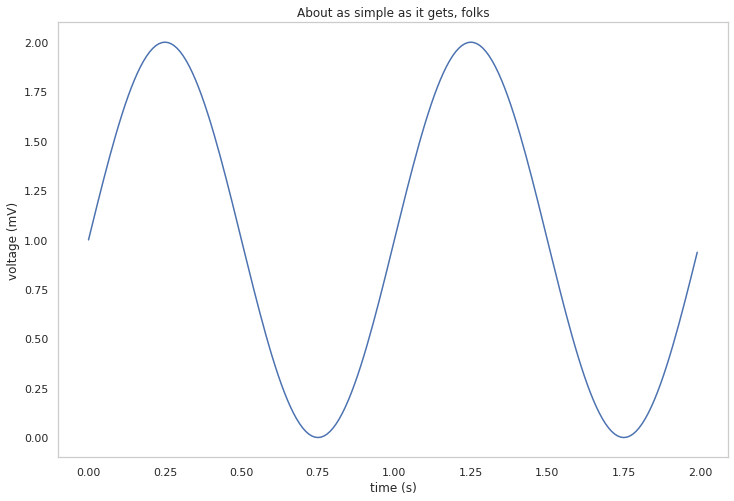

In [200]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()